# chap2-2,2-3

# Datasetの実装

## 画像データ、アノテーションデータへのファイルパスのリストを作成

In [45]:
#パッケージのインポート
import glob
import os.path as osp
import random
import numpy as np
import json
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models,transforms
import cv2 

In [37]:
#学習、検証の画像データとアノテーションデータへのファイルパスリストを作成する
def make_datapath_list(rootpath):
    """ 
    データへのパスを格納したリストを作成する。

    Parameters
    -----------
    rootpath : str
       データフォルダへのパス

    Returns
    -----------
    ret : train_img_list, train_anno_list, val_img_list, val_anno_list
       データへのパスを格納したリスト
    """

    #画像ファイルとアノテーションファイルへのパスのテンプレートを作成
    imgpath_template=osp.join(rootpath,"JPEGImages", "%s.jpg")
    annopath_template=osp.join(rootpath, "Annotations", "%s.xml")

    #訓練と検証、それぞれのファイルのID(ファイル名)を取得する
    train_id_names=osp.join(rootpath+"ImageSets/Main/train.txt")
    val_id_names=osp.join(rootpath+"ImageSets/Main/val.txt")

    #訓練データの画像ファイルとアノテーションファイルへのパスリストを作成
    train_img_list=list()
    train_anno_list=list()

    for line in open(train_id_names):
      file_id=line.strip()
      img_path=(imgpath_template%file_id)
      anno_path=(annopath_template%file_id)
      train_img_list.append(img_path)
      train_anno_list.append(anno_path)
      
   #検証データの画像ファイルとアノテーションファイルへのパスリストを作成
    val_img_list=list()
    val_anno_list=list()

    for line in open(val_id_names):
      file_id=line.strip()
      img_path=(imgpath_template %file_id)
      anno_path=(annopath_template%file_id)
      val_img_list.append(img_path)
      val_anno_list.append(anno_path)

    return train_img_list,train_anno_list,val_img_list,val_anno_list

In [38]:
rootpath="../2_objectdetection/data/VOCdevkit/VOC2012/"
train_id_names=osp.join(rootpath+"ImageSets/Main/train.txt")
train_id_names

'../2_objectdetection/data/VOCdevkit/VOC2012/ImageSets/Main/train.txt'

In [39]:
#open(train_id_names[0])
for i  in open(train_id_names):
    print(i)

2008_000008

2008_000015

2008_000019

2008_000023

2008_000028

2008_000033

2008_000036

2008_000037

2008_000041

2008_000045

2008_000053

2008_000060

2008_000066

2008_000070

2008_000074

2008_000085

2008_000089

2008_000093

2008_000095

2008_000096

2008_000097

2008_000099

2008_000103

2008_000105

2008_000109

2008_000112

2008_000128

2008_000131

2008_000132

2008_000141

2008_000142

2008_000143

2008_000144

2008_000148

2008_000151

2008_000154

2008_000162

2008_000176

2008_000181

2008_000185

2008_000187

2008_000188

2008_000189

2008_000191

2008_000192

2008_000193

2008_000196

2008_000197

2008_000199

2008_000202

2008_000207

2008_000217

2008_000226

2008_000227

2008_000235

2008_000236

2008_000237

2008_000238

2008_000252

2008_000255

2008_000259

2008_000260

2008_000262

2008_000266

2008_000273

2008_000275

2008_000283

2008_000284

2008_000287

2008_000289

2008_000290

2008_000291

2008_000297

2008_000309

2008_000311

2008_000313

2008_000315


In [40]:
for i  in open(train_id_names):
    #print(i.strip())
    file_id=i.strip()
    img_path=imgpath_template%file_id
    print(img_path)


../2_objectdetection/data/VOCdevkit/VOC2012/JPEGImage/2008_000008.jpg
../2_objectdetection/data/VOCdevkit/VOC2012/JPEGImage/2008_000015.jpg
../2_objectdetection/data/VOCdevkit/VOC2012/JPEGImage/2008_000019.jpg
../2_objectdetection/data/VOCdevkit/VOC2012/JPEGImage/2008_000023.jpg
../2_objectdetection/data/VOCdevkit/VOC2012/JPEGImage/2008_000028.jpg
../2_objectdetection/data/VOCdevkit/VOC2012/JPEGImage/2008_000033.jpg
../2_objectdetection/data/VOCdevkit/VOC2012/JPEGImage/2008_000036.jpg
../2_objectdetection/data/VOCdevkit/VOC2012/JPEGImage/2008_000037.jpg
../2_objectdetection/data/VOCdevkit/VOC2012/JPEGImage/2008_000041.jpg
../2_objectdetection/data/VOCdevkit/VOC2012/JPEGImage/2008_000045.jpg
../2_objectdetection/data/VOCdevkit/VOC2012/JPEGImage/2008_000053.jpg
../2_objectdetection/data/VOCdevkit/VOC2012/JPEGImage/2008_000060.jpg
../2_objectdetection/data/VOCdevkit/VOC2012/JPEGImage/2008_000066.jpg
../2_objectdetection/data/VOCdevkit/VOC2012/JPEGImage/2008_000070.jpg
../2_objectdetection

## 「XML形式のアノテーション」を、リスト形式に変換


In [41]:
# 「XML形式のアノテーション」を、リスト形式に変換するクラス


class Anno_xml2list:
    """
    1枚の画像に対する「XML形式のアノテーションデータ」を、画像サイズで規格化してからリスト形式に変換する。

    Attributes
    ----------
    classes : リスト
        VOCのクラス名を格納したリスト
    """

    def __init__(self, classes):

        self.classes = classes

    def __call__(self, xml_path, width, height):
        """
        1枚の画像に対する「XML形式のアノテーションデータ」を、画像サイズで規格化してからリスト形式に変換する。

        Parameters
        ----------
        xml_path : str
            xmlファイルへのパス。
        width : int
            対象画像の幅。
        height : int
            対象画像の高さ。

        Returns
        -------
        ret : [[xmin, ymin, xmax, ymax, label_ind], ... ]
            物体のアノテーションデータを格納したリスト。画像内に存在する物体数分のだけ要素を持つ。
        """

        # 画像内の全ての物体のアノテーションをこのリストに格納します
        ret = []

        # xmlファイルを読み込む
        xml = ET.parse(xml_path).getroot()

        # 画像内にある物体（object）の数だけループする
        for obj in xml.iter('object'):

            # アノテーションで検知がdifficultに設定されているものは除外
            difficult = int(obj.find('difficult').text)
            if difficult == 1:
                continue

            # 1つの物体に対するアノテーションを格納するリスト
            bndbox = []

            name = obj.find('name').text.lower().strip()  # 物体名
            bbox = obj.find('bndbox')  # バウンディングボックスの情報

            # アノテーションの xmin, ymin, xmax, ymaxを取得し、0～1に規格化
            pts = ['xmin', 'ymin', 'xmax', 'ymax']

            for pt in (pts):
                # VOCは原点が(1,1)なので1を引き算して（0, 0）に
                cur_pixel = int(bbox.find(pt).text) - 1

                # 幅、高さで規格化
                if pt == 'xmin' or pt == 'xmax':  # x方向のときは幅で割算
                    cur_pixel /= width
                else:  # y方向のときは高さで割算
                    cur_pixel /= height

                bndbox.append(cur_pixel)

            # アノテーションのクラス名のindexを取得して追加
            label_idx = self.classes.index(name)
            bndbox.append(label_idx)

            # resに[xmin, ymin, xmax, ymax, label_ind]を足す
            ret += [bndbox]

        return np.array(ret)  # [[xmin, ymin, xmax, ymax, label_ind], ... ]


In [34]:
# 動作確認　
voc_classes = ['aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair',
               'cow', 'diningtable', 'dog', 'horse',
               'motorbike', 'person', 'pottedplant',
               'sheep', 'sofa', 'train', 'tvmonitor']

transform_anno = Anno_xml2list(voc_classes)

落書き開始

In [50]:
val_anno_list[ind]

'../2_objectdetection/data/VOCdevkit/VOC2012/Annotations/2008_000003.xml'

In [59]:
xml=ET.parse(val_anno_list[1]).getroot()
print(xml.iter("object"))
print(xml.iter())

In [74]:
for obj in xml.iter("object"):

            # アノテーションで検知がdifficultに設定されているものは除外
            difficult = int(obj.find('difficult').text)
            if difficult == 1:
                continue

In [87]:
for i in xml.iter("object"):
    print(i)
    

<Element 'object' at 0x7f81f12919a8>
<Element 'object' at 0x7f81f1291d18>


In [85]:
for i in xml.iter("object"):
    print(i)

<Element 'object' at 0x7f81f12919a8>
<Element 'object' at 0x7f81f1291d18>


In [82]:
xml.iter()

In [79]:
for i in xml.iter():
    print(i)
    

<Element 'annotation' at 0x7f81c2565a48>
<Element 'folder' at 0x7f81f1291638>
<Element 'filename' at 0x7f81f1291688>
<Element 'source' at 0x7f81f12916d8>
<Element 'database' at 0x7f81f1291728>
<Element 'annotation' at 0x7f81f1291778>
<Element 'image' at 0x7f81f12917c8>
<Element 'size' at 0x7f81f1291818>
<Element 'width' at 0x7f81f1291868>
<Element 'height' at 0x7f81f12918b8>
<Element 'depth' at 0x7f81f1291908>
<Element 'segmented' at 0x7f81f1291958>
<Element 'object' at 0x7f81f12919a8>
<Element 'name' at 0x7f81f12919f8>
<Element 'pose' at 0x7f81f1291a48>
<Element 'truncated' at 0x7f81f1291a98>
<Element 'occluded' at 0x7f81f1291ae8>
<Element 'bndbox' at 0x7f81f1291b38>
<Element 'xmin' at 0x7f81f1291b88>
<Element 'ymin' at 0x7f81f1291bd8>
<Element 'xmax' at 0x7f81f1291c28>
<Element 'ymax' at 0x7f81f1291c78>
<Element 'difficult' at 0x7f81f1291cc8>
<Element 'object' at 0x7f81f1291d18>
<Element 'name' at 0x7f81f1291d68>
<Element 'pose' at 0x7f81f1291db8>
<Element 'truncated' at 0x7f81f1291e

In [91]:
voc_classes.index("bird")

2

In [90]:
voc_classes

['aeroplane',
 'bicycle',
 'bird',
 'boat',
 'bottle',
 'bus',
 'car',
 'cat',
 'chair',
 'cow',
 'diningtable',
 'dog',
 'horse',
 'motorbike',
 'person',
 'pottedplant',
 'sheep',
 'sofa',
 'train',
 'tvmonitor']

落書き終わり

In [92]:
# 画像の読み込み OpenCVを使用
ind = 1
image_file_path = val_img_list[ind]
img = cv2.imread(image_file_path)  # [高さ][幅][色BGR]
height, width, channels = img.shape  # 画像のサイズを取得

# アノテーションをリストで表示
transform_anno(val_anno_list[ind], width, height)

array([[ 0.09      ,  0.03003003,  0.998     ,  0.996997  , 18.        ],
       [ 0.122     ,  0.56756757,  0.164     ,  0.72672673, 14.        ]])

In [97]:
img[0][1]

array([151, 144, 125], dtype=uint8)

In [94]:
img.shape

(333, 500, 3)

## 画像とアノテーションの前処理を行うクラスDataTransformを作成


In [101]:
#フォルダutilsにあるdata_augumentation.pyからインポート
#入力画像の前処理をするクラス
from utils.data_augumentation import Compose,ConvertFromInts,ToAbsoluteCoords, PhotometricDistort,Expand,RandomSampleCrop,RandomMirror,ToPercentCoords,Resize,SubtractMeans

In [158]:
class DataTransform():
    """ 
    画像とアノテーションの前処理クラス。訓練と推論で異なる動作をする。
    画像のサイズは300*300にする。
    学習時はデータオーギュメンテーションをする。

    Attributes
    --------------
    input_size : int
      リサイズ先の画像の大きさ
    color_mean : (B,G,R)
      各色チャネルの平均値
    """

    def __init__(self,input_size,color_mean):
        self.data_transform={
            "train":Compose([
                ConvertFromInts(), #intをfloat32に変換
                ToAbsoluteCoords(), #アノテーションデータの規格化を戻す
                PhotometricDistort(), #画像の色調などをランダムに変化
                Expand(color_mean), #画像のキャンバスを広げる
                RandomSampleCrop(), #画像内の部分をランダムに抜き出す
                RandomMirror(), #画像を反転させる
                ToPercentCoords(), #アノテーションデータを0-1に規格化
                Resize(input_size), #画像サイズをinput_size*input_sizeに変形
                SubtractMeans(color_mean) #BGRの色の平均値を引き算
            ]),
            "val":Compose([
                ConvertFromInts(), #intをfloatに変換
                Resize(input_size), #画像サイズをinput_size*inout_sizeに変形
                SubtractMeans(color_mean) #BGRの色の平均値を引き算
            ])
        }

    def __call__(self,img,phase,boxes,labels):
        """ 
        Parameters
        --------------
        phase : "train" or "val"
             前処理のモードを指定
        """
        return self.data_transform[phase](img,boxes,labels)

In [159]:
#動作確認
#1.画像読み込み
image_file_path=train_img_list[0]
img=cv2.imread(image_file_path) 
height,width,channels=img.shape #画像のサイズを取得




In [160]:
#2. アノテーションをリストに
transform_anno=Anno_xml2list(voc_classes)
anno_list=transform_anno(train_anno_list[0],width,height)
anno_list
#horseとpersonがいる

array([[ 0.104     ,  0.19457014,  0.94      ,  0.9479638 , 12.        ],
       [ 0.314     ,  0.09728507,  0.576     ,  0.37556561, 14.        ]])

In [161]:
train_anno_list[0]


'../2_objectdetection/data/VOCdevkit/VOC2012/Annotations/2008_000008.xml'

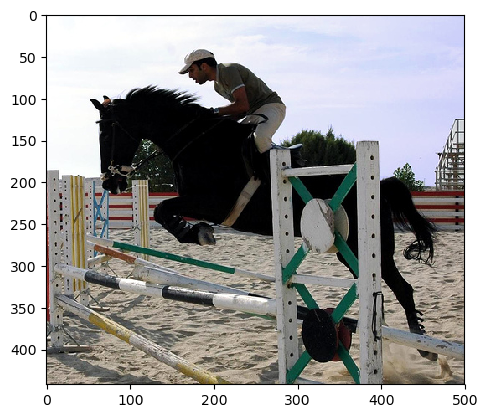

In [162]:
#3. 元画像の表示
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show()

In [163]:
#前処理クラスの作成
color_mean=(104,117,123) #(BGR)の色の平均値
input_size=300 #画像のサイズを300*300にする
transform=DataTransform(input_size,color_mean)


In [185]:
#5. train画像の表示
phase="train"
img_transformed,boxes,label=transform(
    img,phase,anno_list[:,:4],anno_list[:,4]
)
print(boxes)


[[-1.17499999e+08  1.68013040e+07 -1.29999990e+07  8.18575160e+07]
 [-7.19999990e+07  8.40065200e+06 -3.92499990e+07  3.24304240e+07]]


In [134]:
img_transformed

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


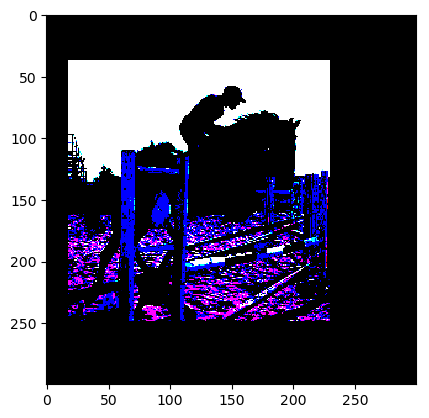

In [135]:
plt.imshow(cv2.cvtColor(img_transformed,cv2.COLOR_BGR2RGB))
plt.show()

In [130]:
transform(img,"train",anno_list[:,:4],anno_list[:,4])

(array([[[235.94458  , 231.026    , 223.12564  ],
         [235.94458  , 231.026    , 223.12564  ],
         [235.8295   , 230.91092  , 223.01056  ],
         ...,
         [194.13495  , 224.23581  , 192.237    ],
         [193.26736  , 222.73969  , 191.55215  ],
         [197.68015  , 225.98517  , 196.30429  ]],
 
        [[235.94458  , 231.026    , 223.12564  ],
         [235.94458  , 231.026    , 223.12564  ],
         [235.8295   , 230.91092  , 223.01056  ],
         ...,
         [195.33127  , 225.43216  , 193.43335  ],
         [194.89206  , 224.95834  , 193.00415  ],
         [198.16074  , 226.83347  , 196.67801  ]],
 
        [[235.94458  , 231.026    , 223.12564  ],
         [235.94458  , 231.026    , 223.12564  ],
         [235.8295   , 230.91092  , 223.01056  ],
         ...,
         [196.55081  , 226.6517   , 194.6529   ],
         [198.31091  , 228.41177  , 196.41296  ],
         [198.38858  , 226.44379  , 195.4881   ]],
 
        ...,
 
        [[ 84.859344 ,  50.69229  

In [119]:
anno_list

array([[ 0.104     ,  0.19457014,  0.94      ,  0.9479638 , 12.        ],
       [ 0.314     ,  0.09728507,  0.576     ,  0.37556561, 14.        ]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


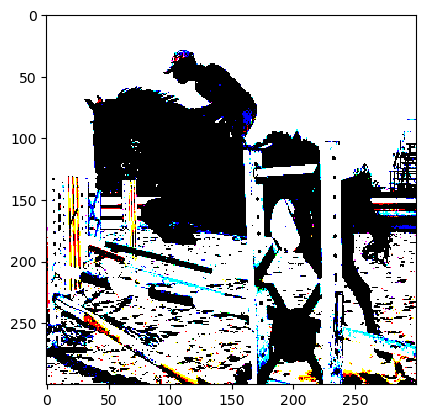

In [137]:
#val画像の表示
phase="val"
img_transformed,boxes,labels=transform(
    img,phase,anno_list[:,:4],anno_list[:,4]
)
plt.imshow(cv2.cvtColor(img_transformed,cv2.COLOR_BGR2RGB))
plt.show()

## Datasetを作成


In [171]:
#VOC2012のDatasetを作成する
class VOCDataset(data.Dataset):
    """ 
    VOC2012のDatasetを作成するクラス。PyTorchのDatasetクラスを継承。

    Attributes
    -----------
    img_list : リスト
        画像のパスを格納したリスト
    anno_list : リスト
        アノテーションへのパスを格納したリスト
    phase : "train" or "test"
        学習か訓練かを設定する
    transform : object
        前処理クラスのインスタンス
    transform_anno : object
        xmlのアノテーションをリストに変換するインスタンス
    """

    def __init__(self,img_list,anno_list,phase,transform,transform_anno):
        self.img_list=img_list
        self.anno_list=anno_list
        self.phase=phase #train or val
        self.transform=transform #画像の変形
        self.transform_anno=transform_anno #アノテーションれーたをxmlからリストへ

    def __len__(self):
        """ 画像の枚数を返す """
        return len(self.img_list)

    def __getitem__(self,index):
        """ 
        前処理した画像のテンソル形式のデータとアノテーションを取得
        """
        im,gt,h,w=self.pull_item(index)
        return im,gt

    def pull_item(self,index):
        """ 前処理した画像のテンソル形式のデータ、アノテーション、画像の高さ、幅を取得する"""

        #1.画像の読み込み
        image_file_path=self.img_list[index]
        img=cv2.imread(image_file_path) #[高さ][幅][色BGR]
        height,width,channels=img.shape #画像サイズを取得

        #2.xml形式のアノテーション情報をリストに
        anno_file_path=self.anno_list[index]
        anno_list=self.transform_anno(anno_file_path,width,height)

        #3.前処理を実施
        img,boxes,labels=self.transform(
            img,self.phase,anno_list[:,:4],anno_list[:,4])
        
        #色チャネルの順番がBGRになっているので、RGBに変更
        #さらに(高さ、幅、色チャネル)の順を(色チャネル、高さ、幅)に変換
        img=torch.from_numpy(img[:,:,(2,1,0)]).permute(2,0,1)

        #BBoxとラベルをセットにしたnp.arrayを作成、変数名gtはground truth(答え)の略称
        gt=np.hstack((boxes,np.expand_dims(labels,axis=1)))

        return img,gt,height,width



In [178]:
a=Anno_xml2list(voc_classes)
a(train_anno_list[0],width,height)

array([[ 0.104     ,  0.19457014,  0.94      ,  0.9479638 , 12.        ],
       [ 0.314     ,  0.09728507,  0.576     ,  0.37556561, 14.        ]])

In [180]:
train_img_list[0]

'../2_objectdetection/data/VOCdevkit/VOC2012/JPEGImages/2008_000008.jpg'

In [188]:
#動作確認
color_mean=(104,117,123) #(BGR)の色の平均値
input_size=300 #画像のinputサイズを300*300にする

train_dataset=VOCDataset(train_img_list,train_anno_list,phase="train", 
                 transform=DataTransform(input_size,color_mean),transform_anno=Anno_xml2list(voc_classes))
                
val_dataset=VOCDataset(val_img_list,val_anno_list,phase="val", 
                 transform=DataTransform(input_size,color_mean),transform_anno=Anno_xml2list(voc_classes))

#データの取り出し例
train_dataset.__getitem__(0)


(tensor([[[ 51.5554,  52.1834,  53.1867,  ...,  72.1785,  71.6333,  73.3694],
          [ 51.5554,  51.9291,  52.9500,  ...,  81.9017,  79.3602,  71.2529],
          [ 51.5554,  51.8694,  53.2521,  ...,  23.8832,  65.6858,  63.5820],
          ...,
          [ -5.6404,  -0.1758, -26.6204,  ...,   7.1940,   3.2390, -13.9550],
          [ -1.0119, -13.4391, -50.3038,  ...,  31.4850,  32.1667,  18.1362],
          [-18.2573, -15.4608, -45.4697,  ...,  37.2606,  22.2562,  19.7439]],
 
         [[ 57.5554,  58.1834,  59.1867,  ...,  78.9941,  77.9473,  79.3694],
          [ 57.5554,  57.9291,  58.9500,  ...,  88.7174,  85.6742,  77.2529],
          [ 57.5554,  57.8694,  59.2521,  ...,  30.4992,  71.7853,  69.5820],
          ...,
          [-11.0192,  -5.5545, -31.9991,  ...,   5.9794,   4.7452, -10.0156],
          [ -7.6575, -20.3706, -57.0447,  ...,  30.1116,  32.6445,  20.9698],
          [-23.1751, -21.8836, -50.8892,  ...,  36.7352,  22.7340,  20.8498]],
 
         [[ 99.9198,  99.919

# DataLoaderの実装

In [189]:
def od_collate_fn(batch):
    """ 
     Datasetから取り出すアノテーションデータのサイズが画像ごとに異なります。
     画像内の物体が2個であれば(2,5)というサイズですが、3個であれば(3,5)などと変化します。
     この変化に対応したDataLoaderを作成するために、カスタマイズしたcollate_fnを作成します。
     collate_fnはPyTorchでリストからmini-batchを作成する関数です。
     ミニバッチ分の画像が並んでるリスト変数batchに、
     ミニバッチ番号を指定する次元を先頭に1つ追加して、リストの形を変形します。
    """

    targets=[]
    imgs=[]
    for sample in batch:
        imgs.append(sample[0]) #sample[0]は画像です。
        targets.append(torch.FloatTensor(sample[1])) #sample[1]はアノテーション
                                                     #gtです
    
    #imgはミニバッチサイズのリストになっています
    #リストの要素はtorch.Size([3,300,300])です
    #このリストをtorch.Size([batch_num,3,300,300])のテンソルに変換します
    imgs=torch.stack(imgs,dim=0)

    #targetsはアノテーションデータのリストになっています。
    #リストのサイズはミニバッチサイズです
    #リストtargetsの要素は[n,5]となっています
    #nは画像ごとに異なり、画像内にある物体の数となります
    #5は[xmin,ymin,xmax,ymax,class_index]です

    return imgs,targets 

In [190]:
#データローダーの作成
batch_size=4

train_dataloader=data.DataLoader(
    train_dataset,batch_size=batch_size,shuffle=True,collate_fn=od_collate_fn)

val_dataloader=data.DataLoader(
    val_dataset,batch_size=batch_size,shuffle=False,collate_fn=od_collate_fn
)

#辞書型変数にまとめる
dataloaders_dict={"train":train_dataloader, "val":val_dataloader}

#動作確認
batch_iterator=iter(dataloaders_dict["val"]) #イテレータに変換
images,targets=next(batch_iterator) #1番目の要素を取り出す
print(images.size())
print(len(targets))
print(targets[1].size()) #ミニバッチのサイズリスト、各要素は[n,5],nは物体数



torch.Size([4, 3, 300, 300])
4
torch.Size([2, 5])


In [192]:
print(train_dataset.__len__())
print(val_dataset.__len__())

5717
5823


落書き

In [193]:
batch_iterator

In [209]:
dataloaders_dict["val"]

In [208]:
import torch

#2×3の行列をテンソルとして準備
x = torch.randn(2, 3)
x_list = []
x_list.append(x)
x_list.append(x)
x_list.append(x)
x_list


[tensor([[-0.5894, -0.4345, -1.4288],
         [-0.8926,  1.7495, -0.9950]]),
 tensor([[-0.5894, -0.4345, -1.4288],
         [-0.8926,  1.7495, -0.9950]]),
 tensor([[-0.5894, -0.4345, -1.4288],
         [-0.8926,  1.7495, -0.9950]])]

In [198]:
x=[[0.2378,  0.2739,  0.0442],[-0.0746,  1.0030,  1.1256]]
x_list=[]
x_list.append(x)
x_list.append(x)
x_list.append(x)
x_list

[[[0.2378, 0.2739, 0.0442], [-0.0746, 1.003, 1.1256]],
 [[0.2378, 0.2739, 0.0442], [-0.0746, 1.003, 1.1256]],
 [[0.2378, 0.2739, 0.0442], [-0.0746, 1.003, 1.1256]]]

In [ ]:
print(torch.stack(x_list))

""" 
---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
/var/folders/6_/zpjxt4sx4kn92ky_w1lbwjmr0000gn/T/ipykernel_7974/2210446784.py in <module>
----> 1 print(torch.stack(x_list))

TypeError: expected Tensor as element 0 in argument 0, but got list
"""

In [196]:
x_list

[tensor([[ 0.2378,  0.2739,  0.0442],
         [-0.0746,  1.0030,  1.1256]]),
 tensor([[ 0.2378,  0.2739,  0.0442],
         [-0.0746,  1.0030,  1.1256]]),
 tensor([[ 0.2378,  0.2739,  0.0442],
         [-0.0746,  1.0030,  1.1256]])]

In [197]:
print(torch.stack(x_list))

tensor([[[ 0.2378,  0.2739,  0.0442],
         [-0.0746,  1.0030,  1.1256]],

        [[ 0.2378,  0.2739,  0.0442],
         [-0.0746,  1.0030,  1.1256]],

        [[ 0.2378,  0.2739,  0.0442],
         [-0.0746,  1.0030,  1.1256]]])
